# 0 Import Libraries and Data

In [1]:
# import libraries 
import pandas as pd # Import Pandas for data manipulation using dataframes
import numpy as np # Import Numpy for data statistical analysis 
import matplotlib.pyplot as plt # Import matplotlib for data visualisation

import random
import seaborn as sns

import torch
import torch.nn as nn

import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

realestate_df = pd.read_csv("/content/gdrive/MyDrive/ColabNotebooks/RealEstate/data_with_locations_and_ids.csv")
print(f"Length before droping duplicate ids = {len(realestate_df)}")
realestate_df =realestate_df.drop_duplicates(subset=['id'], keep='first')
print(f"Length after droping duplicate ids = {len(realestate_df)}")

Mounted at /content/gdrive
Length before droping duplicate ids = 2857086
Length after droping duplicate ids = 596409


In [3]:
sample_df=realestate_df.sample(frac=0.95, replace=False, random_state=99)
sample_df["Price"] = pd.to_numeric(sample_df["Price"], downcast="float")
sample_df['Time_Posted'] = sample_df['Time_Posted'].values.astype('datetime64[ns]')
sample_df.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



,Price,Location_x,Listing_Type,Time_Posted,Time_Retrieved,Location_y,lat,lng,area_1,area_2,Region,Sub_Region,Sub_Region_Type,id
1426228,1975.0,Ottawa,Apartments-Condos,2021-12-27 05:31:33.921,2021-12-27 01:06:33.921000-05:00,Ottawa,45.339412,-75.681050,Hunt Club - Ottawa Airport,Ottawa,Ottawa,Ottawa,Cité,-7851574446298523165
135428,2625.0,North York,Apartments-Condos,2022-02-25 23:31:21.199,2022-02-25 19:02:21.199000-05:00,City of Toronto,43.742466,-79.317061,North York,Toronto,Toronto,Toronto,Cité,4491342929523575349
2116426,2000.0,Windsor Region,Apartments-Condos,2022-02-27 00:04:30.731,2022-02-26 22:04:30.731000-05:00,Windsor,42.323621,-82.960178,Riverside,Windsor,Essex,Windsor,Cité,1502820194724401079


In [4]:
print(f"Length before removing outliers = {len(sample_df)}")

listings=sample_df['Listing_Type'].unique()
dataframe_list=[]

for value in listings:
    df = sample_df[sample_df.Listing_Type==value]
    q_low = df["Price"].quantile(0.05)
    q_hi  = df["Price"].quantile(0.95)
    df = df[(df["Price"] < q_hi) & (df["Price"] > q_low)]
    
    dataframe_list.append(df)
    
sample_df = pd.concat(dataframe_list, axis=0, ignore_index=True) 

print(f"Length after removing outliers = {len(sample_df)}")

Length before removing outliers = 566589
Length after removing outliers = 508534


In [5]:
listing_type_dict={}

listing_types=sample_df['Listing_Type'].unique()

for type in listing_types:
    listing_type_dict[type]=sample_df[sample_df['Listing_Type']==type]

print(listing_type_dict.keys())

dict_keys(['Apartments-Condos', 'House-For-Sale', 'Room-Rental-Roommate', 'Commercial-Office-Space-For-Sale', 'Short-Term-Rental', 'Condo-For-Sale', 'Commercial-Office-Space', 'Storage-Parking', 'Land-For-Sale'])


# 1 EDA

In [6]:
fig = make_subplots(rows=len(listing_types),subplot_titles=[listing for listing in listing_types])

for index, listing in enumerate(listing_types):


    df=listing_type_dict[listing][['Time_Posted', 'Price']].groupby(pd.Grouper(key="Time_Posted", freq="1W")).agg({'Price': ['median', 'mean']}).dropna()
    df.columns=df.columns.map('_'.join)
    df=df.reset_index()

    data1=go.Scatter(x=df['Time_Posted'], y=df['Price_median'],
                        mode='lines',
                        name='median',
                        line=dict(color='#abd7eb'))
    data2=go.Scatter(x=df['Time_Posted'], y=df['Price_mean'],
                        mode='lines',
                        name='mean',
                        line=dict(color='#F47174'))

    fig.add_traces([data1,data2],rows=(index+1),cols=1)




fig.update_layout(title_text=f"Listing Price and Time", height=2000)
fig.show()

In [7]:
print('Listing Types')
print(sample_df['Listing_Type'].unique())
print()
print('Sub Regions')
print(sample_df['Sub_Region'].value_counts().head(20).index)

Listing Types
['Apartments-Condos' 'House-For-Sale' 'Room-Rental-Roommate'
 'Commercial-Office-Space-For-Sale' 'Short-Term-Rental' 'Condo-For-Sale'
 'Commercial-Office-Space' 'Storage-Parking' 'Land-For-Sale']

Sub Regions
Index(['Toronto', 'Ottawa', 'Brampton', 'Mississauga', 'Hamilton', 'London',
       'Windsor', 'Kitchener', 'Vaughan', 'Oshawa', 'Markham', 'Oakville',
       'Richmond Hill', 'Burlington', 'Waterloo', 'Barrie', 'St. Catharines',
       'Milton', 'Guelph', 'Kingston'],
      dtype='object')


In [8]:
_specify= (sample_df['Listing_Type']=='Apartments-Condos') & (sample_df['Sub_Region']=='Toronto')

In [9]:
df=sample_df[_specify][['Time_Posted', 'Price']].groupby(pd.Grouper(key="Time_Posted", freq="1W")).agg({'Price': ['median', 'mean']}).dropna()
df.columns=df.columns.map('_'.join)
mean_df=df[['Price_mean']]
median_df=df[['Price_median']]

df.head()

,Price_median,Price_mean
Time_Posted,,
2021-10-24,1572.5,1572.500000
2021-11-07,2222.0,2113.444336
2021-11-14,2149.0,2088.882324
2021-11-21,1878.0,1872.604614
2021-11-28,1885.0,1918.655151


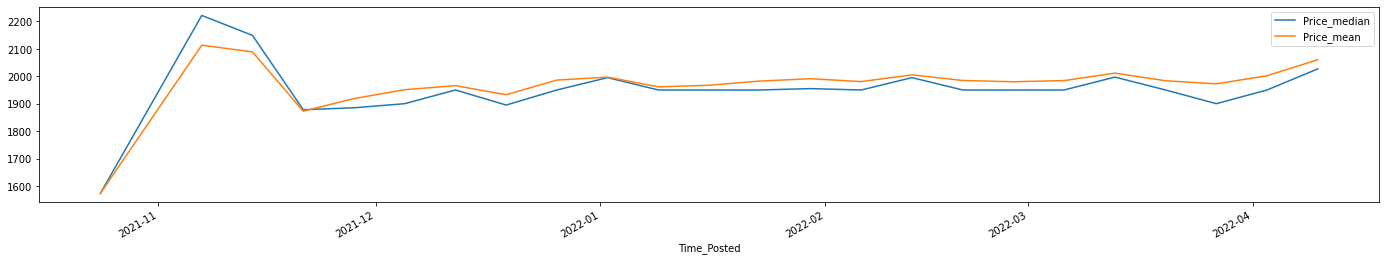

In [10]:
df.plot(figsize=(24,4))

# 2 Setting Up for Modeling

In [11]:
y=df['Price_median'].values

test_size=4
train_set=y[:-test_size]
test_set=y[-test_size:]

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_set.reshape(-1,1))
train_norm=scaler.transform(train_set.reshape(-1,1))
train_norm

array([[-1.        ],
       [ 1.        ],
       [ 0.7752118 ],
       [-0.0592761 ],
       [-0.03772116],
       [ 0.00846815],
       [ 0.16243267],
       [-0.00692844],
       [ 0.16243267],
       [ 0.30100107],
       [ 0.16243267],
       [ 0.16243267],
       [ 0.16243267],
       [ 0.17782927],
       [ 0.16243267],
       [ 0.30100107],
       [ 0.16243267],
       [ 0.16243267],
       [ 0.16243267],
       [ 0.30715942]], dtype=float32)

In [13]:
train_norm = torch.FloatTensor(train_norm).view(-1)
train_norm

tensor([-1.0000,  1.0000,  0.7752, -0.0593, -0.0377,  0.0085,  0.1624, -0.0069,
         0.1624,  0.3010,  0.1624,  0.1624,  0.1624,  0.1778,  0.1624,  0.3010,
         0.1624,  0.1624,  0.1624,  0.3072])

In [14]:
window_size=4

# Define function to create seq/label tuples
def input_data(_sequence,_windowsize):
    out = []
    L = len(_sequence)

    for i in range(L-_windowsize):
        window = _sequence[i:i+_windowsize]
        label = _sequence[i+_windowsize:i+_windowsize+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal len(original data)-len(test size)-len(window size)

16

# 3 Define Model

In [15]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

In [16]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [17]:
epochs = 20000

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    
 
    if epoch%1000 == 1:
        
    # print training result
      print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  2 Loss: 0.01655444
Epoch: 1002 Loss: 0.00491530
Epoch: 2002 Loss: 0.00440294
Epoch: 3002 Loss: 0.00418336
Epoch: 4002 Loss: 0.00443318
Epoch: 5002 Loss: 0.00434668
Epoch: 6002 Loss: 0.00433543
Epoch: 7002 Loss: 0.00436710
Epoch: 8002 Loss: 0.00433012
Epoch: 9002 Loss: 0.00431124
Epoch: 10002 Loss: 0.00430198
Epoch: 11002 Loss: 0.00427888
Epoch: 12002 Loss: 0.00425860
Epoch: 13002 Loss: 0.00425689
Epoch: 14002 Loss: 0.00422844
Epoch: 15002 Loss: 0.00425163
Epoch: 16002 Loss: 0.00427327
Epoch: 17002 Loss: 0.00425655
Epoch: 18002 Loss: 0.00424897
Epoch: 19002 Loss: 0.00425739

Duration: 530 seconds


# 4 Compare with Test Set

In [18]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())


preds[window_size:] 


[0.1608624905347824,
 0.13591009378433228,
 0.16143280267715454,
 0.24194252490997314,
 0.16522754728794098,
 0.2419198453426361,
 0.16138407588005066,
 0.24304278194904327,
 0.1298220157623291,
 0.24390017986297607,
 0.004572182893753052,
 0.24434134364128113]

In [19]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[1949.49005029],
       [1941.38675919],
       [1949.67525916],
       [1975.82079228],
       [1950.90760251],
       [1975.81342709],
       [1949.65943513],
       [1976.17810076],
       [1939.40965579],
       [1976.45654075],
       [1898.73477128],
       [1976.59980869]])

In [20]:
df['Price_median'][-12:]

Time_Posted
2022-01-23    1950.0
2022-01-30    1955.0
2022-02-06    1950.0
2022-02-13    1995.0
2022-02-20    1950.0
2022-02-27    1950.0
2022-03-06    1950.0
2022-03-13    1997.0
2022-03-20    1950.0
2022-03-27    1900.0
2022-04-03    1950.0
2022-04-10    2027.0
Name: Price_median, dtype: float32

In [21]:
time_change = df.index[-1]-df.index[-2]
time_change

Timedelta('7 days 00:00:00')

In [22]:
min_range=df['Price_mean'][-12:].index.min()
max_range=df['Price_mean'][-12:].index.max()

x = np.arange(min_range, max_range+time_change, dtype='datetime64[W]').astype('datetime64[D]')
x

array(['2022-01-20', '2022-01-27', '2022-02-03', '2022-02-10',
       '2022-02-17', '2022-02-24', '2022-03-03', '2022-03-10',
       '2022-03-17', '2022-03-24', '2022-03-31', '2022-04-07'],
      dtype='datetime64[D]')

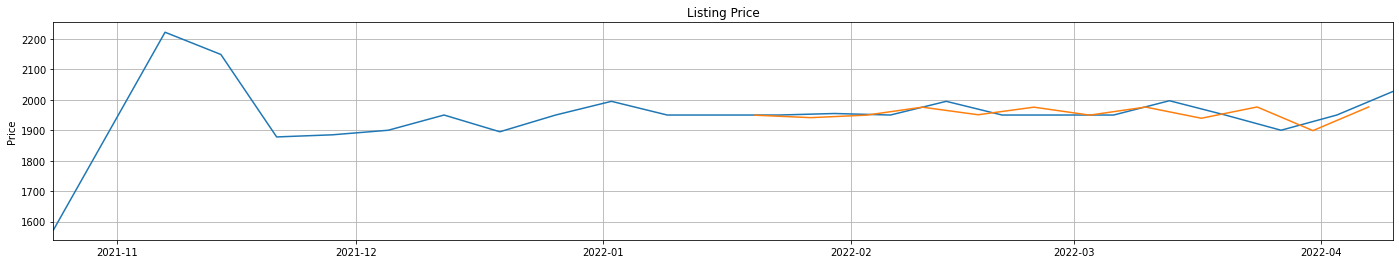

In [23]:
plt.figure(figsize=(24,4))
plt.title('Listing Price')
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Price_median'])
plt.plot(x,true_predictions)
plt.show()

In [24]:
x.shape

(12,)

# 5 Forecast into unknown future

In [25]:
epochs = 20000

# set model back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    if epoch%500 == 1:  
    # print training result
      print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  2 Loss: 0.02392398
Epoch: 502 Loss: 0.00006207
Epoch: 1002 Loss: 0.00005534
Epoch: 1502 Loss: 0.00011271
Epoch: 2002 Loss: 0.00003374
Epoch: 2502 Loss: 0.00000001
Epoch: 3002 Loss: 0.00001029
Epoch: 3502 Loss: 0.00000003
Epoch: 4002 Loss: 0.00000000
Epoch: 4502 Loss: 0.00000103
Epoch: 5002 Loss: 0.00000000
Epoch: 5502 Loss: 0.00002171
Epoch: 6002 Loss: 0.00000000
Epoch: 6502 Loss: 0.00000355
Epoch: 7002 Loss: 0.00000010
Epoch: 7502 Loss: 0.00000022
Epoch: 8002 Loss: 0.00001760
Epoch: 8502 Loss: 0.00001919
Epoch: 9002 Loss: 0.00000578
Epoch: 9502 Loss: 0.00000970
Epoch: 10002 Loss: 0.00000679
Epoch: 10502 Loss: 0.00000562
Epoch: 11002 Loss: 0.00000086
Epoch: 11502 Loss: 0.00000386
Epoch: 12002 Loss: 0.00000087
Epoch: 12502 Loss: 0.00000139
Epoch: 13002 Loss: 0.00001053
Epoch: 13502 Loss: 0.00000000
Epoch: 14002 Loss: 0.00000302
Epoch: 14502 Loss: 0.00000000
Epoch: 15002 Loss: 0.00000359
Epoch: 15502 Loss: 0.00000008
Epoch: 16002 Loss: 0.00000038
Epoch: 16502 Loss: 0.00000164
Epo

In [26]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

In [27]:
true_predictions.shape

(24, 1)

In [28]:
min_range=df['Price_mean'][-window_size:].index.min()
max_range=df['Price_mean'][-window_size:].index.max()

time_change = df.index[-1]-df.index[-2]
time_change

Timedelta('7 days 00:00:00')

In [29]:
future_min_range=max_range+time_change
future_max_range=max_range+(time_change*(window_size+1))

In [30]:
x = np.arange(future_min_range, future_max_range, dtype='datetime64[W]').astype('datetime64[D]')
x.shape

(12,)

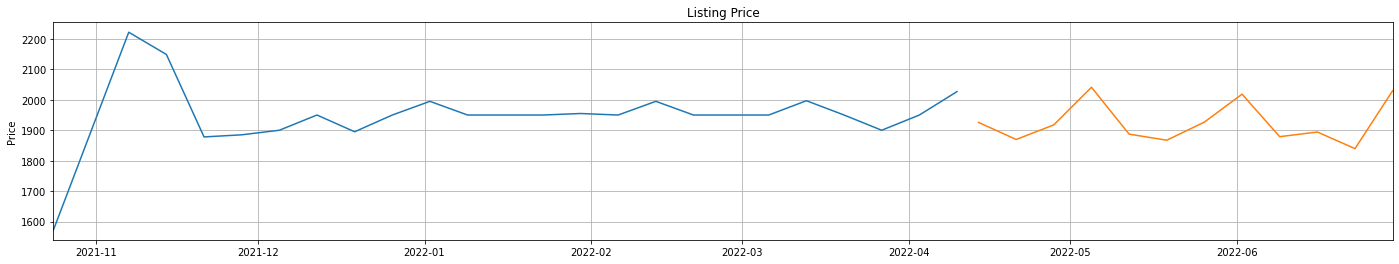

In [31]:
# PLOT THE RESULT
# Set a data range for the predicted data.
# Remember that the stop date has to be later than the last predicted value.



plt.figure(figsize=(24,4))
plt.title('Listing Price')
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Price_median'])
plt.plot(x,true_predictions[window_size:])
plt.show()